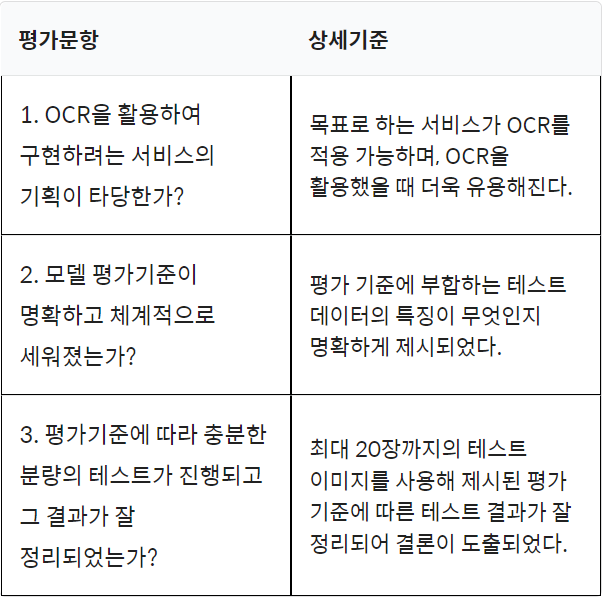

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

import keras_ocr
import pytesseract

import pytesseract
from PIL import Image
from pytesseract import Output
from glob import glob

print(keras_ocr.__version__)
print(pytesseract.__version__)
# pytesseract는 tesseract-ocr에 종속적입니다. 아래 명령어를 통해 설치해야 할 수도 있습니다.
# !sudo apt install tesseract-ocr

0.8.8
0.3.8


# 1. 검증용 데이터셋 준비

In [2]:
image_path = os.getenv('HOME') + '/aiffel/ocr_python/'
img_list = glob(image_path + '*.jpg')
img_list.sort()
img_list

['/aiffel/aiffel/ocr_python/book_1.jpg',
 '/aiffel/aiffel/ocr_python/book_2.jpg',
 '/aiffel/aiffel/ocr_python/book_3.jpg',
 '/aiffel/aiffel/ocr_python/book_4.jpg',
 '/aiffel/aiffel/ocr_python/book_5.jpg',
 '/aiffel/aiffel/ocr_python/book_6.jpg']

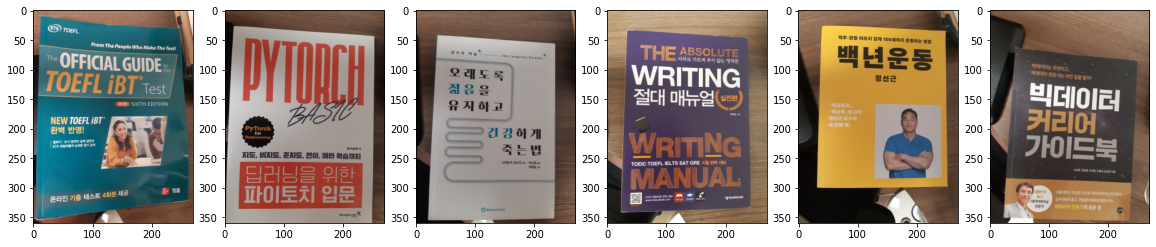

In [3]:
# 이미지 출력
plt.figure(figsize=(20, 20))
for i, im in enumerate(img_list):
    plt.subplot(1, 6, i+1)
    image = img.imread(im)
    plt.imshow(image)

# 2. keras-ocr, Tesseract로 테스트 진행(Google OCR API는 선택 사항)

## 2-1. keras-ocr

In [4]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [5]:
images_keras_ocr = [keras_ocr.tools.read(image) for image in img_list]
prediction_groups = [pipeline.recognize([image]) for image in img_list]

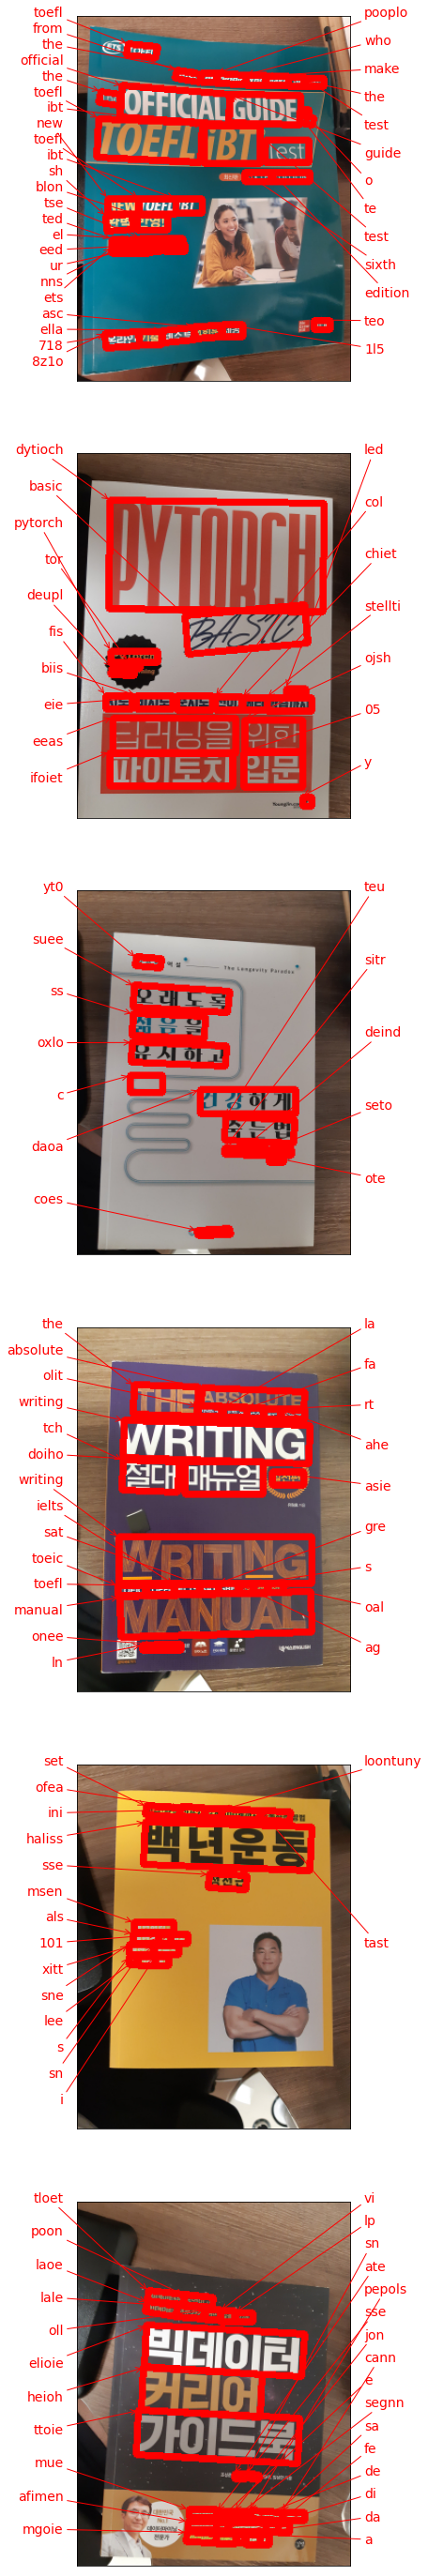

In [6]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images_keras_ocr), figsize=(50, 50))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images_keras_ocr[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

## 2-2. Tesseract

In [7]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='kor',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path = work_dir + '/test_image.png'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

FileNotFoundError: [Errno 2] No such file or directory: '/aiffel/aiffel/ocr_python/test_image.png'

In [ ]:
cropped_image_path_list = {}
for i, img in enumerate(img_list):
    dir_path = work_dir + f'/{i}'
    path_list = crop_word_regions(img, dir_path)
    cropped_image_path_list[i] = path_list

In [ ]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='kor',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

# 3. 테스트 결과 정리

keras-ocr은 한글 인식 불가하였다.
Tsseract은 문제가 발생하여 사진을 다시찍고 편집헤서 업로드후 수행하였는데도 오류가 발생하였다.

# 4. 결과 분석과 결론 제시

현재 핸드폰이나 다른 IT기기에 적용되는 기술이어서 어색하지 않았지만 다른 AI관련기술과 마찬가지고 아직 갈길이 먼것 같다. 특히 한글에 기술이 부족해서 정부차원에서 투자와 노력이 필요한 것 같다.